# Hubble Source Catalog SWEEPS Proper Motion (API Version)
### 2019 - 2022, Steve Lubow, Rick White, Trenton McKinney

A [new MAST interface][1] supports queries to the current and previous versions of the [Hubble Source Catalog][2]. It allows searches of the summary table (with multi-filter mean photometry) and the detailed table (with all the multi-epoch measurements). It also has an associated [API][3], which is used in this notebook.

The [web-based user interface][4] to the HSC does not currently include access to the new proper motions available for the [SWEEPS][5] field in version 3.1 of the [Hubble Source Catalog][2]. However those tables are accessible via the API. This notebook shows how to use them.

This notebook is similar to the [previously released version][6] that uses CasJobs rather than the new API. The Casjobs interface is definitely more powerful and flexible, but the API is simpler to use for users who are not already experienced Casjobs users. Currently the API does not include easy access to the colors and magnitudes of the SWEEPS objects, but they will be added soon.

Additional information is available on the [SWEEPS Proper Motions help page][7].

A notebook that provides a quick introduction to the HSC API is also [available][8]. Another [notebook][9] generates a color-magnitude diagram for the Small Magellanic Cloud in only a couple of minutes.


  [1]: https://catalogs.mast.stsci.edu/hsc
  [2]: https://archive.stsci.edu/hst/hsc
  [3]: https://catalogs.mast.stsci.edu/docs/hsc.html
  [4]: https://catalogs.mast.stsci.edu/hsc
  [5]: https://media.stsci.edu/news_release/news/2011-16
  [6]: ../SWEEPS_HSCV3P1/sweeps_hscv3p1.ipynb
  [7]: https://archive.stsci.edu/hst/hsc/help/sweeps/hsc_sweeps_pm.html
  [8]: ../HSCV3_API/hscv3_api.ipynb
  [9]: ../HSCV3_SMC_API/hscv3_smc_api.ipynb

# Instructions: 
* Complete the initialization steps [described below](#Initialization).
* Run the notebook to completion. 
* Modify and rerun any sections of the Table of Contents below.

Running the notebook from top to bottom takes about 
4 minutes (depending on the speed of your computer).


# Table of Contents
* [Initialization](#Initialization)
* [Properties of Full Catalog](#fullcat)
    * [Sky Coverage](#SkyCoverage)
    * [Proper Motion Distributions](#pmhist)
    * [Visit Distribution](#visitshist)
    * [Time Coverage Distributions](#timehist)
    * [Detection Positions](#detpos)
    * [Positions for a Sample With Good PMs](#good_sample)
* [Science Applications](#sciap)
    * [High Proper Motion Objects](#hpm)
    * [HLA Cutout Images for Selected Objects](#cutouts)

# Initialization <a class="anchor" id="Initialization"></a>

### Install Python modules

1. _This notebook requires the use of **Python 3**._
1. Modules can be installed with `conda`, if using the [Anaconda distribution][1] of python, or with `pip`.
   - If you are using `conda`, do not install / update / remove a module with `pip`, that exists in a `conda` [channel][2].
   - If a module is not available with `conda`, then it's okay to install it with `pip`


  [1]: https://www.anaconda.com/products/distribution
  [2]: https://docs.conda.io/projects/conda/en/latest/user-guide/concepts/channels.html

In [1]:
import astropy
import time
import sys
import os
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path

## For handling ordinary astropy Tables
from astropy.table import Table
from astropy.io import fits, ascii

from PIL import Image
from io import BytesIO

from fastkde import fastKDE
from scipy.interpolate import RectBivariateSpline
from astropy.modeling import models, fitting

# There are a number of relatively unimportant warnings that 
# show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")

# set width for pprint
astropy.conf.max_width = 150

In [2]:
# set universal matplotlib parameters
plt.rcParams.update({'font.size': 16})

### MAST API functions

- Execute HSC searches and resolve names using [MAST query][1].
- Here we define several interrelated functions for retrieving information from the MAST API.
  - The `hcvcone(ra, dec, radius [, keywords])` function searches the HCV catalog near a position.
  - The `hcvsearch()` function performs general non-positional queries.
  - The `hcvmetadata()` function gives information about the columns available in a table. 


  [1]: https://mast.stsci.edu/api/v0/MastApiTutorial.html

In [3]:
hscapiurl = "https://catalogs.mast.stsci.edu/api/v0.1/hsc"


def hsccone(ra, dec, radius, table="summary", release="v3", format="csv", magtype="magaper2",
            columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a cone search of the HSC catalog
    
    Parameters
    ----------
    ra (float): (degrees) J2000 Right Ascension
    dec (float): (degrees) J2000 Declination
    radius (float): (degrees) Search radius (<= 0.5 degrees)
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2)
    """
    
    data = kw.copy()
    data['ra'] = ra
    data['dec'] = dec
    data['radius'] = radius
    return hscsearch(table=table, release=release, format=format, magtype=magtype,
                     columns=columns, baseurl=baseurl, verbose=verbose, **data)


def hscsearch(table="summary", release="v3", magtype="magaper2", format="csv",
              columns=None, baseurl=hscapiurl, verbose=False, **kw):
    """Do a general search of the HSC catalog (possibly without ra/dec/radius)
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    format: csv, votable, json
    columns: list of column names to include (None means use defaults)
    baseurl: base URL for the request
    verbose: print info about request
    **kw: other parameters (e.g., 'numimages.gte':2).  Note this is required!
    """
    
    data = kw.copy()
    if not data:
        raise ValueError("You must specify some parameters for search")
    if format not in ("csv", "votable", "json"):
        raise ValueError("Bad value for format")
    url = "{}.{}".format(cat2url(table, release, magtype, baseurl=baseurl), format)
    if columns:
        # check that column values are legal
        # create a dictionary to speed this up
        dcols = {}
        for col in hscmetadata(table, release, magtype)['name']:
            dcols[col.lower()] = 1
        badcols = []
        for col in columns:
            if col.lower().strip() not in dcols:
                badcols.append(col)
        if badcols:
            raise ValueError(f"Some columns not found in table: {', '.join(badcols)}")
        # two different ways to specify a list of column values in the API
        # data['columns'] = columns
        data['columns'] = f"[{','.join(columns)}]"

    # either get or post works
    # r = requests.post(url, data=data)
    r = requests.get(url, params=data)

    if verbose:
        print(r.url)
    r.raise_for_status()
    if format == "json":
        return r.json()
    else:
        return r.text


def hscmetadata(table="summary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return metadata for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns an astropy table with columns name, type, description
    """
    url = "{}/metadata".format(cat2url(table, release, magtype, baseurl=baseurl))
    r = requests.get(url)
    r.raise_for_status()
    v = r.json()
    # convert to astropy table
    tab = Table(rows=[(x['name'], x['type'], x['description']) for x in v],
                names=('name', 'type', 'description'))
    return tab


def cat2url(table="summary", release="v3", magtype="magaper2", baseurl=hscapiurl):
    """Return URL for the specified catalog and table
    
    Parameters
    ----------
    table (string): summary, detailed, propermotions, or sourcepositions
    release (string): v3 or v2
    magtype (string): magaper2 or magauto (only applies to summary table)
    baseurl: base URL for the request
    
    Returns a string with the base URL for this request
    """
    checklegal(table, release, magtype)
    if table == "summary":
        url = f"{baseurl}/{release}/{table}/{magtype}"
    else:
        url = f"{baseurl}/{release}/{table}"
    return url


def checklegal(table, release, magtype):
    """Checks if this combination of table, release and magtype is acceptable
    
    Raises a ValueError exception if there is problem
    """
    
    releaselist = ("v2", "v3")
    if release not in releaselist:
        raise ValueError(f"Bad value for release (must be one of {', '.join(releaselist)})")
    if release == "v2":
        tablelist = ("summary", "detailed")
    else:
        tablelist = ("summary", "detailed", "propermotions", "sourcepositions")
    if table not in tablelist:
        raise ValueError(f"Bad value for table (for {release} must be one of {', '.join(tablelist)})")
    if table == "summary":
        magtypelist = ("magaper2", "magauto")
        if magtype not in magtypelist:
            raise ValueError(f"Bad value for magtype (must be one of {', '.join(magtypelist)})")

### Use metadata query to get information on available columns

This query works for any of the tables in the API (summary, detailed, propermotions, sourcepositions).

In [4]:
meta = hscmetadata("propermotions")
print(' '.join(meta['name']))
meta[:5]

objID numSources raMean decMean lonMean latMean raMeanErr decMeanErr lonMeanErr latMeanErr pmRA pmDec pmLon pmLat pmRAErr pmDecErr pmLonErr pmLatErr pmRADev pmDecDev pmLonDev pmLatDev epochStart epochEnd epochMean DSigma NumFilters NumVisits NumImages CI CI_Sigma KronRadius KronRadius_Sigma HTMID X Y Z


<Table length=5>
   name     type        description       
  str16     str5           str31          
---------- ----- -------------------------
     objID  long      objID_descriptionTBD
numSources   int numSources_descriptionTBD
    raMean float     raMean_descriptionTBD
   decMean float    decMean_descriptionTBD
   lonMean float    lonMean_descriptionTBD

### Retrieve data on selected SWEEPS objects

This makes a single large request to the HSC search interface to the get the contents of the proper motions table.  Despite its large size (460K rows), the query is relatively efficient: it takes about 25 seconds to retrieve the results from the server, and then another 20 seconds to convert it to an astropy table.  The speed of the table conversion will depend on your computer.

Note that the query restricts the sample to objects with at least 20 images total spread over at least 10 different visits.
These constraints can be modified depending on your science goals.

In [5]:
columns = """ObjID,raMean,decMean,raMeanErr,decMeanErr,NumFilters,NumVisits,
    pmLat,pmLon,pmLatErr,pmLonErr,pmLatDev,pmLonDev,epochMean,epochStart,epochEnd""".split(",")
columns = [x.strip() for x in columns]
columns = [x for x in columns if x and not x.startswith('#')]

# missing -- impossible with current data I think
# MagMed, n, MagMAD

constraints = {'NumFilters.gt': 1, 'NumVisits.gt': 9, 'NumImages.gt': 19}

# note the pagesize parameter, which allows retrieving very large results
# the default pagesize is 50000 rows

t0 = time.time()
results = hscsearch(table="propermotions", release='v3', columns=columns, verbose=True, pagesize=500000, **constraints)
print("{:.1f} s: retrieved data".format(time.time()-t0))
tab = ascii.read(results)
print(f"{(time.time()-t0):.1f} s: converted to astropy table")

# change some column names for consistency with the Casjobs version of this notebook
tab.rename_column("raMean", "RA")
tab.rename_column("decMean", "Dec")
tab.rename_column("raMeanErr", "RAerr")
tab.rename_column("decMeanErr", "Decerr")
tab.rename_column("pmLat", "bpm")
tab.rename_column("pmLon", "lpm")
tab.rename_column("pmLatErr", "bpmerr")
tab.rename_column("pmLonErr", "lpmerr")

# compute some additional columns

tab['pmdev'] = np.sqrt(tab['pmLonDev']**2+tab['pmLatDev']**2)
tab['yr'] = (tab['epochMean'] - 47892)/365.25+1990
tab['dT'] = (tab['epochEnd']-tab['epochStart'])/365.25
tab['yrStart'] = (tab['epochStart'] - 47892)/365.25+1990
tab['yrEnd'] = (tab['epochEnd'] - 47892)/365.25+1990

# delete some columns that are not needed after the computations
del tab['pmLonDev'], tab['pmLatDev'], tab['epochEnd'], tab['epochStart'], tab['epochMean']

tab

https://catalogs.mast.stsci.edu/api/v0.1/hsc/v3/propermotions.csv?pagesize=500000&NumFilters.gt=1&NumVisits.gt=9&NumImages.gt=19&columns=%5BObjID%2CraMean%2CdecMean%2CraMeanErr%2CdecMeanErr%2CNumFilters%2CNumVisits%2CpmLat%2CpmLon%2CpmLatErr%2CpmLonErr%2CpmLatDev%2CpmLonDev%2CepochMean%2CepochStart%2CepochEnd%5D
70.7 s: retrieved data


79.8 s: converted to astropy table


<Table length=462899>
    ObjID             RA                 Dec                RAerr        ...         dT              yrStart             yrEnd       
    int64          float64             float64             float64       ...      float64            float64            float64      
------------- ------------------ ------------------- ------------------- ... ------------------ ------------------ ------------------
4000709002872 269.80265870673486 -29.205957243690076   8.906592991633994 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002873 269.80378770789946 -29.205974835994052  0.7096218032444195 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002876 269.82296821680706 -29.205896476716422  0.7706973473790779 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002877  269.8332548589135 -29.205868155225808 0.27424667855226753 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
4000709002878   269.835302632853  -29.20587073819387  0.1879999828118465 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
4000709002879  269.8277124425253  -29.20589825505979    1.00245020275521 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002880 269.82272881885933 -29.205986311573078  0.9257625226909163 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002881 269.82473057730886 -29.205937709115002  1.4568115693488992 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002882  269.8276616511264  -29.20597130494826  0.7870640877273638 ... 11.371914541371764 2003.4361796620085 2014.8080942033803
4000709002883 269.83454067783856  -29.20590020834723  0.4720721237054502 ... 3.0067822490178155 2011.8013119543625 2014.8080942033803
          ...                ...                 ...                 ... ...                ...                ...                ...
4000805716072 269.75349922919384  -29.18723752907607   2.225441886958637 ...  5.219308377861273  2010.356355274077 2015.5756636519384
4000805716573 269.74337423557154 -29.187417348173906  2.2057221630623087 ...  5.216772221613989  2010.356355274077  2015.573127495691
4000805716797 269.75311840756876   -29.1875254442458  2.9271667402623693 ...  5.219308377861273  2010.356355274077 2015.5756636519384
4000805718205  269.7531594948824  -29.18815017514315  0.5494108385351802 ...  5.218033788614816 2010.3576298633234 2015.5756636519384
4000805718227 269.75302524494737 -29.188080987508073  0.2567567729208505 ...  5.219308377861273  2010.356355274077 2015.5756636519384
4000805721823  269.7695982219451 -29.175803921966573  1.2464516090926194 ...   7.50342572353459 2006.1859879667713 2013.6894136903059
4000805722552  269.7505635379468 -29.176124301646208  1.3508567271806144 ... 10.200037916489888 2004.1467026849632  2014.346740601453
4000805728345  269.7539224541331 -29.178794521368257 0.42735895669302787 ... 2.1380438612573855 2013.4376197906809 2015.5756636519384
4000805728821  269.7537554562008 -29.178900030499676  0.6515493691149903 ... 2.1380438612573855 2013.4376197906809 2015.5756636519384
4000805729371  269.7539432727861  -29.17923921402182  0.9428707849288095 ...  7.150233691270112 2010.3810252001922 2017.5312588914621

# Properties of Full Catalog  <a class="anchor" id="fullcat"></a>

## Sky Coverage  <a class="anchor" id="SkyCoverage"></a>

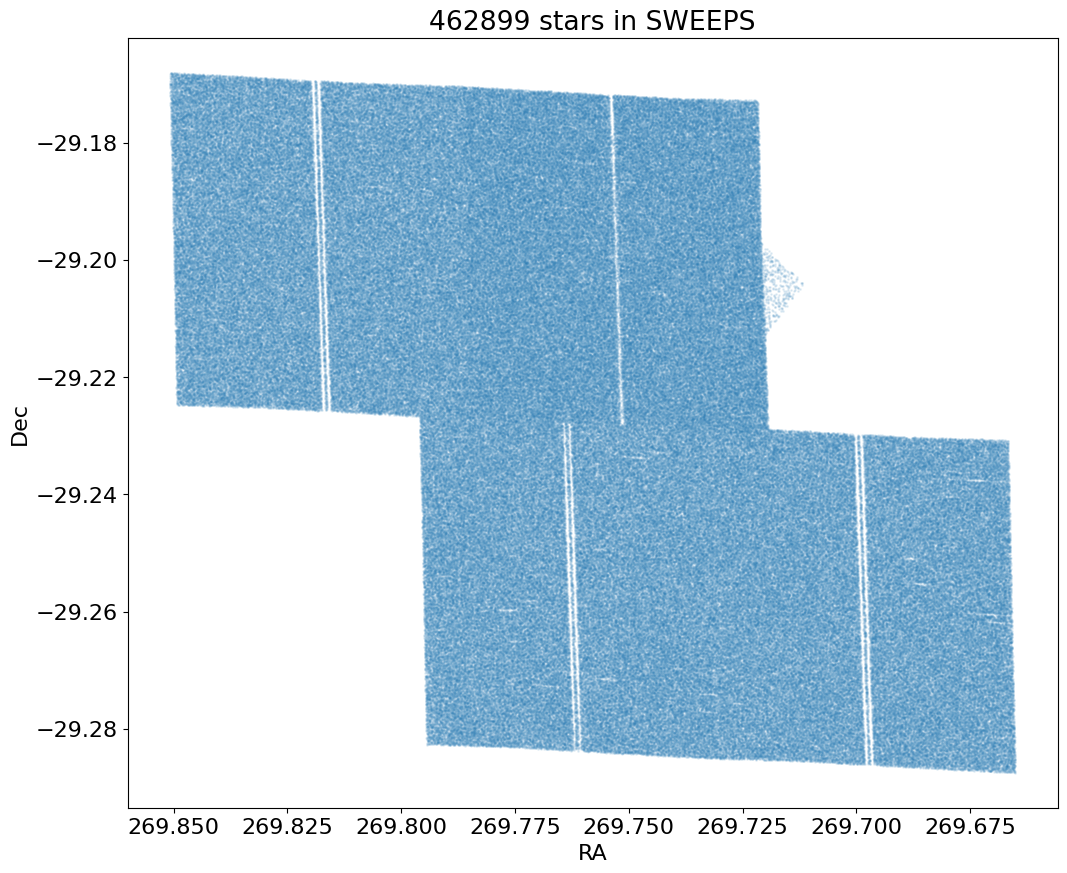

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter('RA', 'Dec', data=tab, s=1, alpha=0.1)
ax.set(xlabel='RA', ylabel='Dec', title=f'{len(tab)} stars in SWEEPS')
ax.invert_xaxis()

# Proper Motion Histograms <a class="anchor" id="pmhist"></a>

## Proper motion histograms for lon and lat 

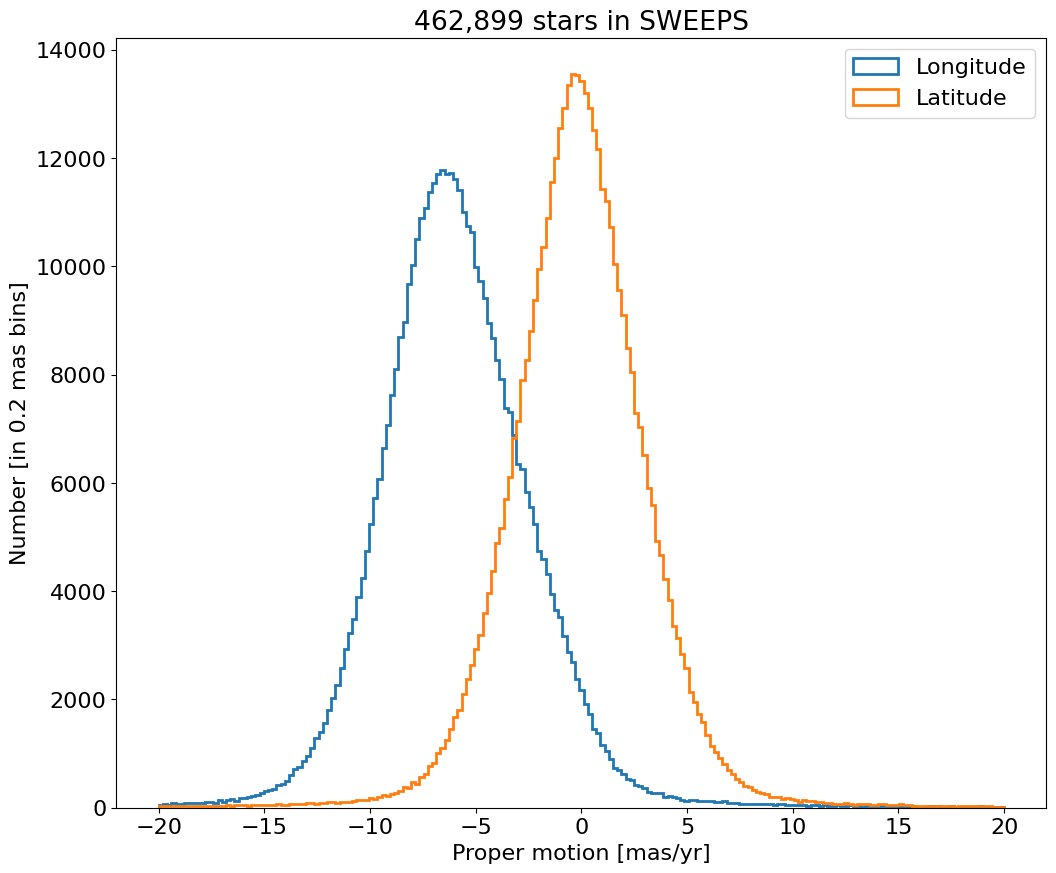

In [7]:
bins = 0.2
hrange = (-20, 20)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1

fig, ax = plt.subplots(figsize=(12, 10))
for col, label in zip(['lpm', 'bpm'], ['Longitude', 'Latitude']):
    ax.hist(col, data=tab, range=hrange, bins=bincount, label=label, histtype='step', linewidth=2)
ax.set(xlabel='Proper motion [mas/yr]', ylabel=f'Number [in {bins:.2} mas bins]', title=f'{len(tab):,} stars in SWEEPS')
_ = ax.legend()

## Proper motion error cumulative histogram for lon and lat

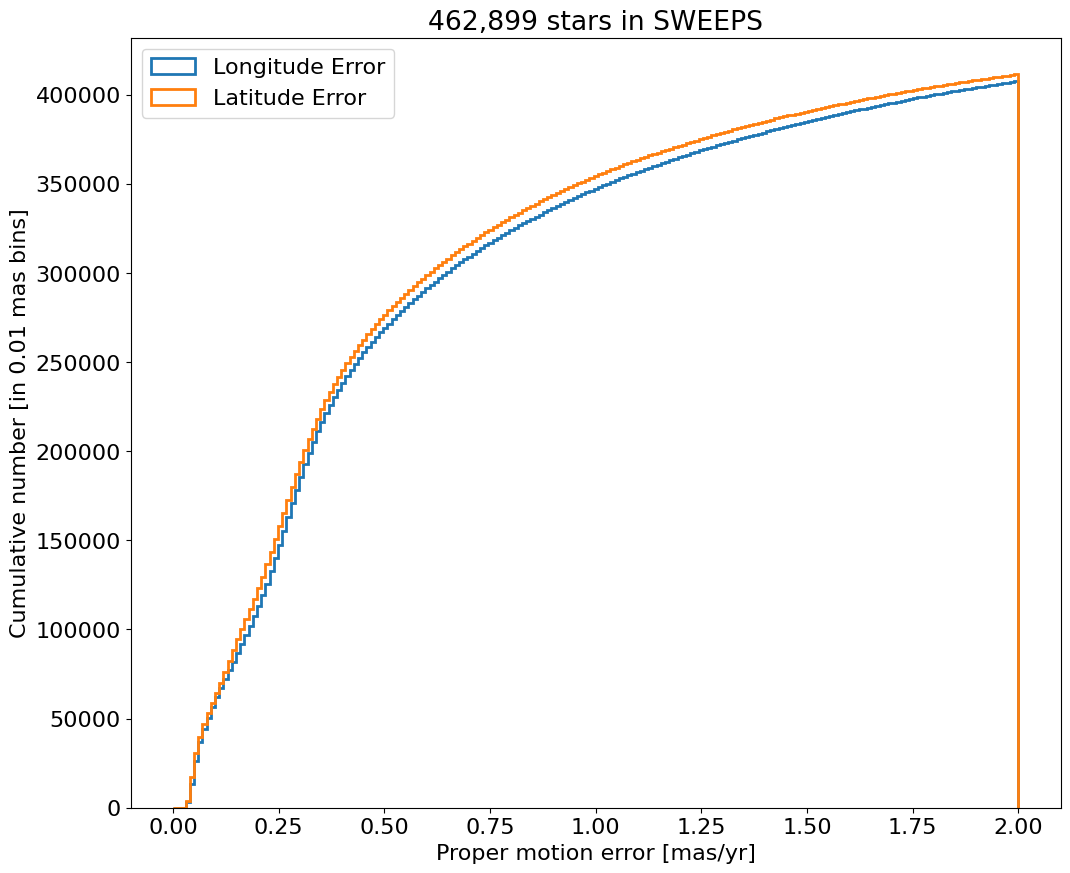

In [8]:
bins = 0.01
hrange = (0, 2)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1

fig, ax = plt.subplots(figsize=(12, 10))
for col, label in zip(['lpmerr', 'bpmerr'], ['Longitude Error', 'Latitude Error']):
    ax.hist(col, data=tab, range=hrange, bins=bincount, label=label, histtype='step', cumulative=1, linewidth=2)
ax.set(xlabel='Proper motion error [mas/yr]', ylabel=f'Cumulative number [in {bins:0.2} mas bins]', title=f'{len(tab):,} stars in SWEEPS')
_ = ax.legend(loc='upper left')

## Proper motion error log histogram for lon and lat 

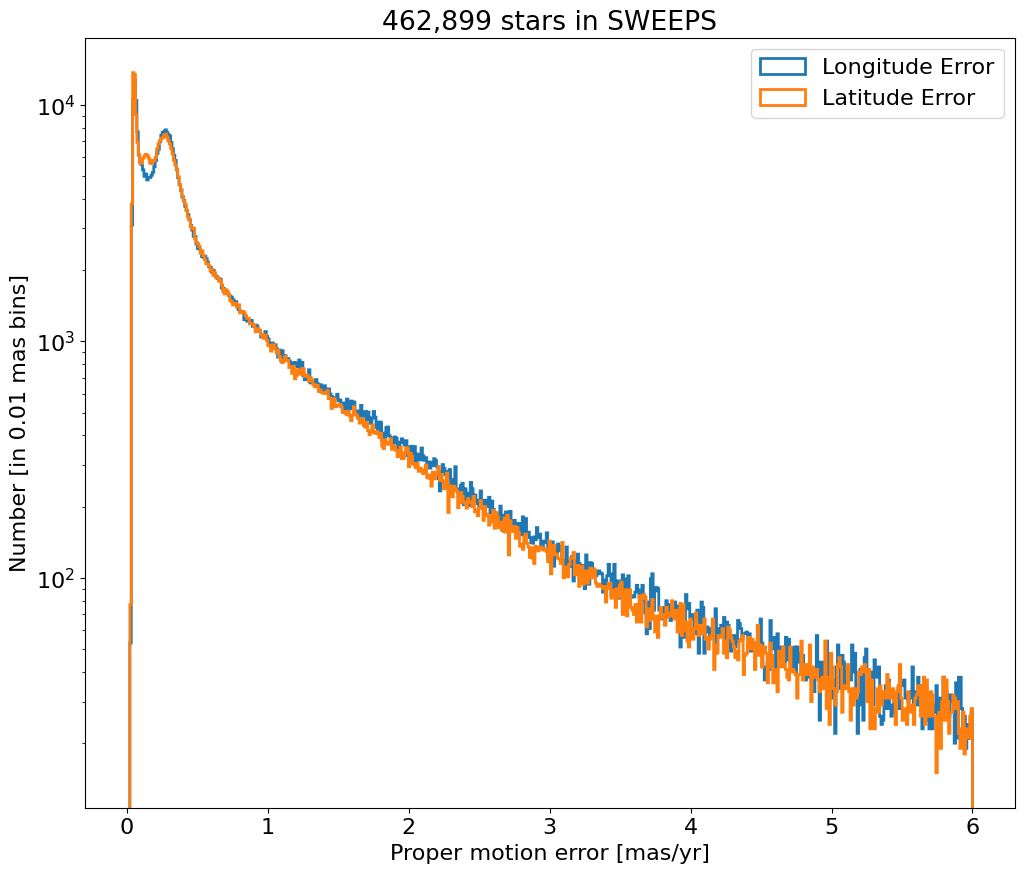

In [9]:
bins = 0.01
hrange = (0, 6)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1

fig, ax = plt.subplots(figsize=(12, 10))
for col, label in zip(['lpmerr', 'bpmerr'], ['Longitude Error', 'Latitude Error']):
    ax.hist(col, data=tab, range=hrange, bins=bincount, label=label, histtype='step', linewidth=2)
ax.set(xlabel='Proper motion error [mas/yr]', ylabel=f'Number [in {bins:0.2} mas bins]', title=f'{len(tab):,} stars in SWEEPS', yscale='log')
_ = ax.legend(loc='upper right')

## Proper motion error as a function of dT

Exclude objects with dT near zero, and to improve the plotting add a bit of random noise to spread out the quanitized time values.

In [10]:
# restrict to sources with dT > 1 year
dtmin = 1.0
w = np.where(tab['dT'] > dtmin)[0]
if ('rw' not in locals()) or len(rw) != len(w):
    rw = np.random.random(len(w))
x = np.array(tab['dT'][w]) + 0.5*(rw-0.5)
y = np.log(np.array(tab['lpmerr'][w]))

# Calculate the point density
t0 = time.time()
myPDF, axes = fastKDE.pdf(x, y, numPoints=2**9+1)
print(f"kde took {(time.time()-t0):.1f} sec")

# interpolate to get z values at points
finterp = RectBivariateSpline(axes[1], axes[0], myPDF)
z = finterp(y, x, grid=False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
xs, ys, zs = x[idx], y[idx], z[idx]

# select a random subset of points in the most crowded regions to speed up plotting
wran = np.where(np.random.random(len(zs))*zs < 0.05)[0]
print(f"Plotting {len(wran)} of {len(zs)} points")
xs = xs[wran]
ys = ys[wran]
zs = zs[wran]

kde took 1.6 sec


Plotting 190081 of 461199 points


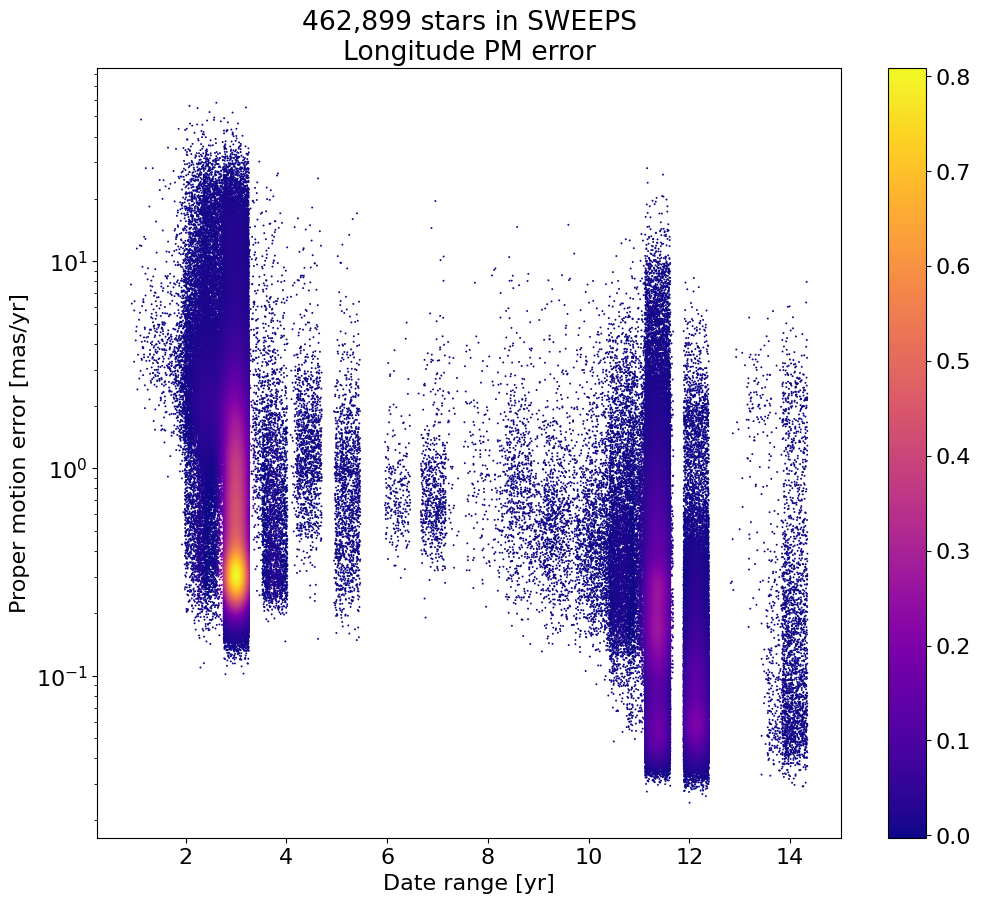

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
sc = ax.scatter(xs, np.exp(ys), c=zs, s=2, edgecolors='none', cmap='plasma')
ax.set(xlabel='Date range [yr]', ylabel='Proper motion error [mas/yr]',
       title=f'{len(tab):,} stars in SWEEPS\nLongitude PM error', yscale='log')
_ = fig.colorbar(sc, ax=ax)

## Proper motion error log histogram for lon and lat 

Divide sample into points with $<6$ years of data and points with more than 6 years of data.

In [12]:
bins = 0.01
hrange = (0, 6)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1
tsplit = 6

# select the data to plot
mask = tab['dT'] <= tsplit
data1 = tab[mask]
data2 = tab[~mask]

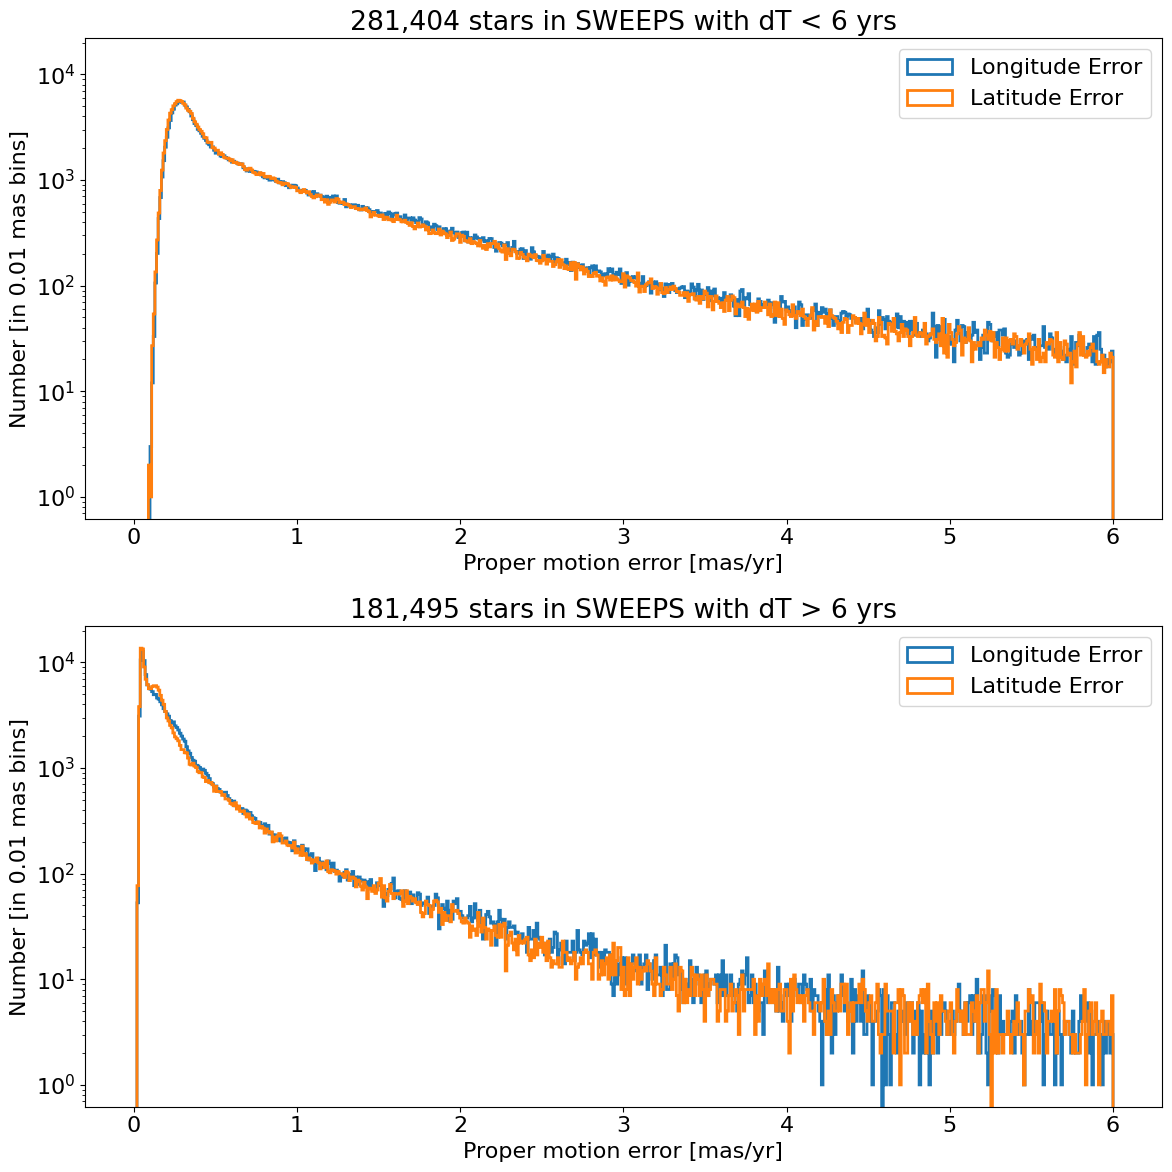

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharey=True)

for ax, data in zip([ax1, ax2], [data1, data2]):
    for col, label in zip(['lpmerr', 'bpmerr'], ['Longitude Error', 'Latitude Error']):
        ax.hist(col, data=data, range=hrange, bins=bincount, label=label, histtype='step', linewidth=2)
    
ax1.set(xlabel='Proper motion error [mas/yr]', ylabel=f'Number [in {bins:0.2} mas bins]',
        title=f'{len(data1):,} stars in SWEEPS with dT < {tsplit} yrs', yscale='log')
ax2.set(xlabel='Proper motion error [mas/yr]', ylabel=f'Number [in {bins:0.2} mas bins]',
        title=f'{len(data2):,} stars in SWEEPS with dT > {tsplit} yrs', yscale='log')

ax1.legend()
ax2.legend()

_ = fig.tight_layout()

# Number of Visits Histogram <a class="anchor" id="visitshist"></a>

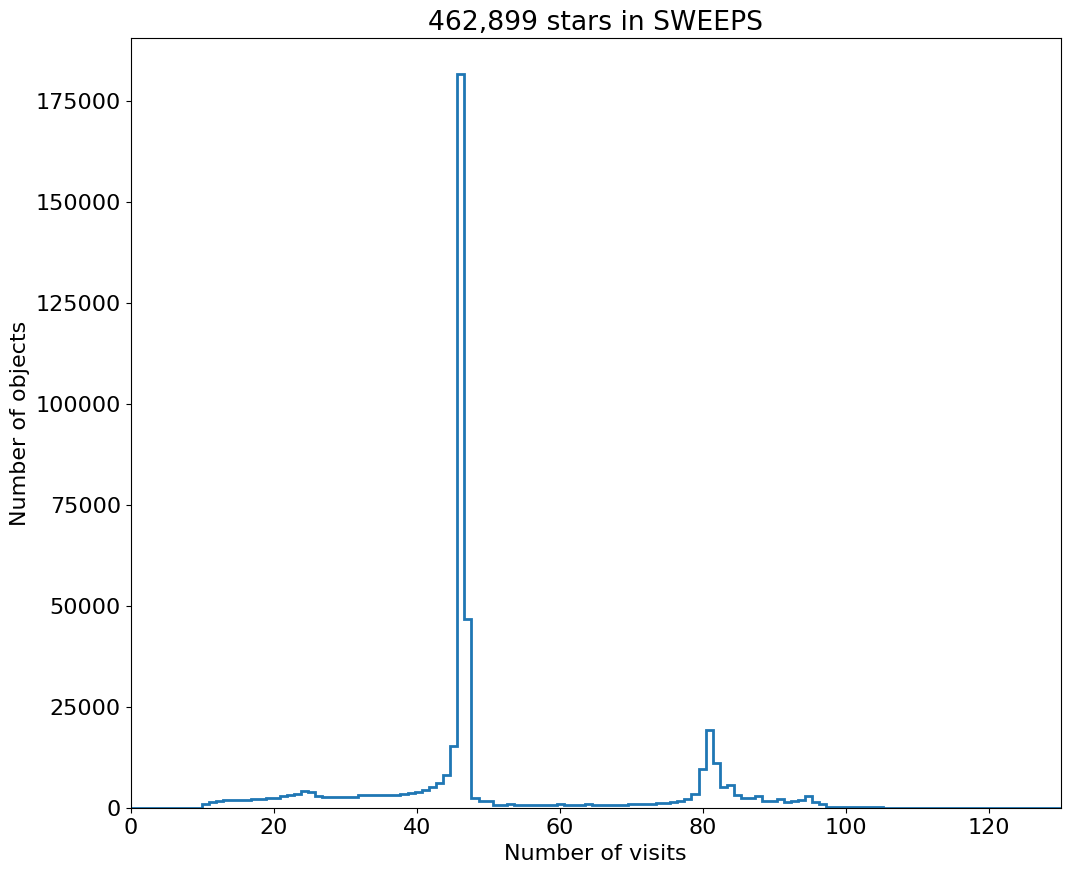

In [14]:
bins = 1
hrange = (0, 130)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1

fig, ax = plt.subplots(figsize=(12, 10))
ax.hist('NumVisits', data=tab, range=hrange, bins=bincount, label='Number of visits ', histtype='step', linewidth=2)
ax.set(xlabel='Number of visits', ylabel='Number of objects', title=f'{len(tab):,} stars in SWEEPS')
_ = ax.margins(x=0)

# Time Histograms <a class="anchor" id="timehist"></a>

First plot histogram of observation dates.

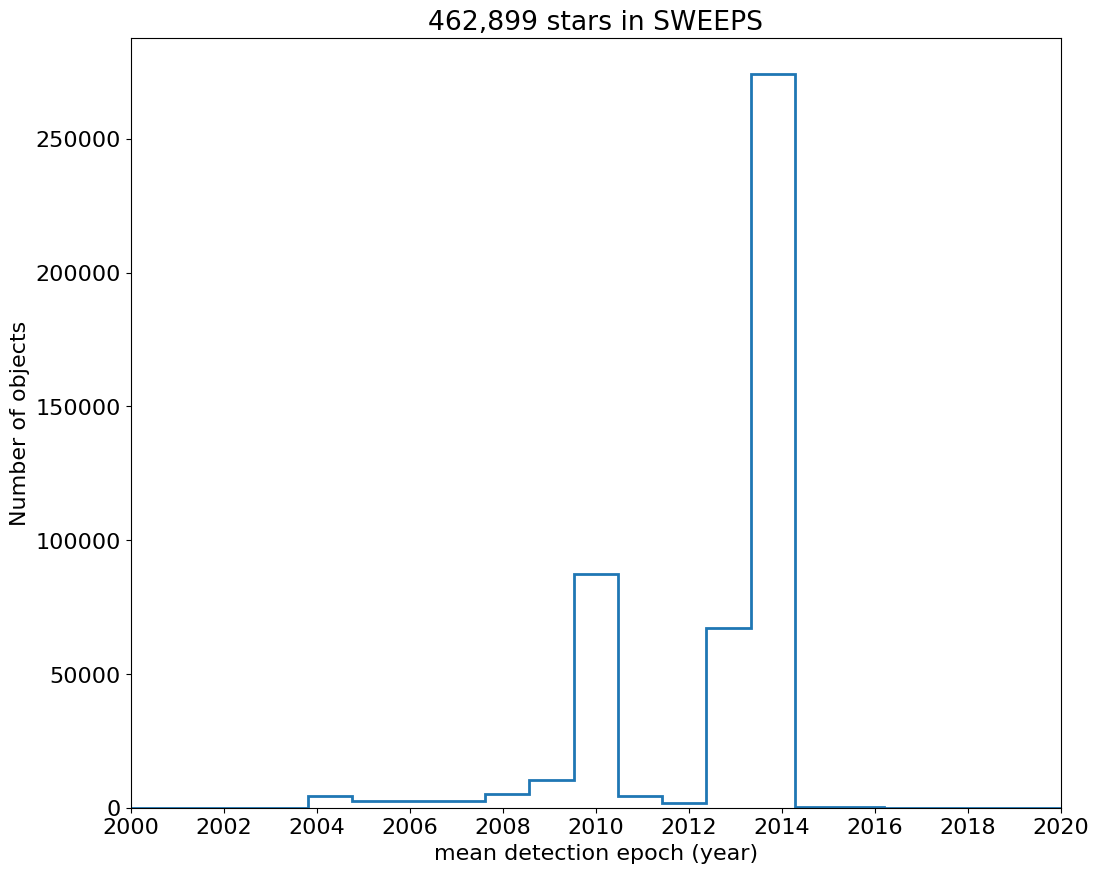

In [15]:
bins = 1
hrange = (2000, 2020)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1

fig, ax = plt.subplots(figsize=(12, 10))
ax.hist('yr', data=tab, range=hrange, bins=bincount, label='year ', histtype='step', linewidth=2)
ax.set(xlabel='mean detection epoch (year)', ylabel='Number of objects', title=f'{len(tab):,} stars in SWEEPS')
ax.set_xticks(ticks=range(2000, 2021, 2))
_ = ax.margins(x=0)

Then plot histogram of observation duration for the objects.

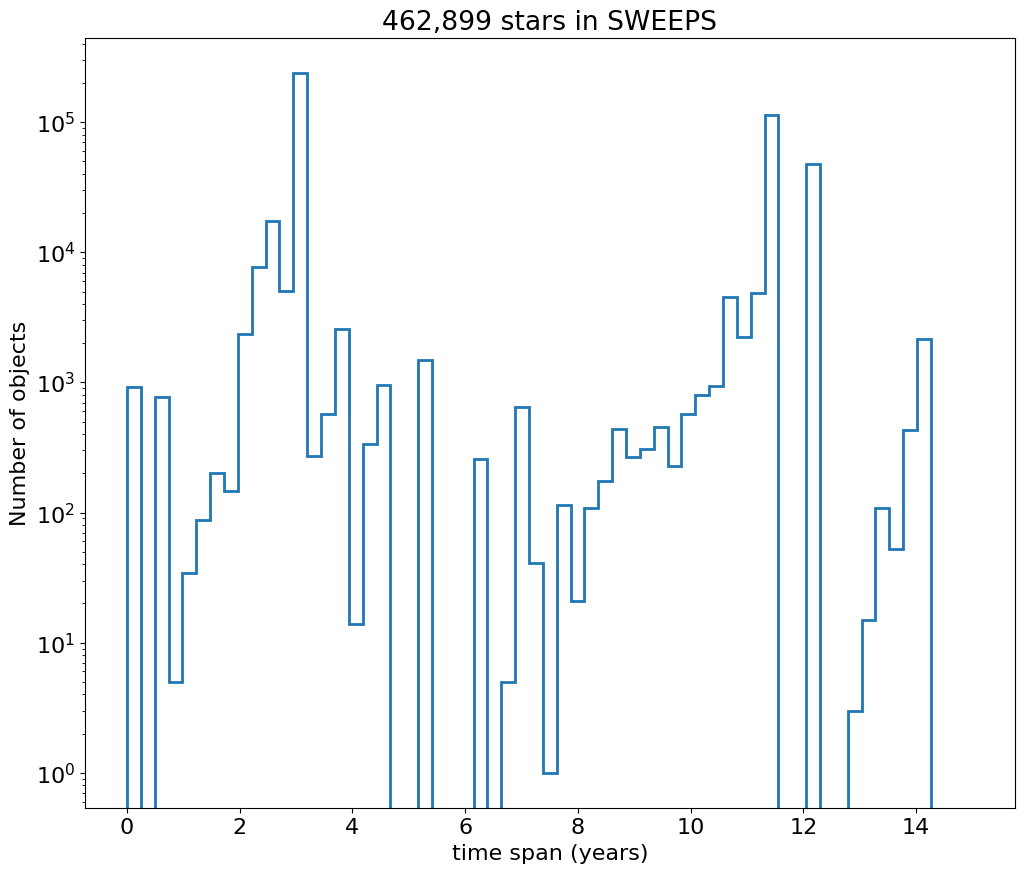

In [16]:
bins = 0.25
hrange = (0, 15)
bincount = int((hrange[1]-hrange[0])/bins + 0.5) + 1

fig, ax = plt.subplots(figsize=(12, 10))
ax.hist('dT', data=tab, range=hrange, bins=bincount, label='year ', histtype='step', linewidth=2)
_ = ax.set(xlabel='time span (years)', ylabel='Number of objects', title=f'{len(tab):,} stars in SWEEPS', yscale='log')

# Detection Positions <a class="anchor" id="detpos"></a>

Define a function to plot the PM fit for an object.

In [17]:
# define function
def positions(Obj):
    """
    input parameter Obj is the value of the ObjID 
    output plots change in (lon, lat) as a function of time
    overplots proper motion fit
    provides ObjID and proper motion information in labels
    """

    # get the measured positions as a function of time
    pos = ascii.read(hscsearch("sourcepositions", columns="dT,dLon,dLat".split(','), objid=Obj))
    pos.sort('dT')
    
    # get the PM fit parameters
    pm = ascii.read(hscsearch("propermotions", columns="pmlon,pmlonerr,pmlat,pmlaterr".split(','), objid=Obj))
    
    lpm = pm['pmlon'][0]
    bpm = pm['pmlat'][0]
    
    # get the intercept for the proper motion fit referenced to the start time
    # time between mean epoch and zero (ref) epoch (years)

    x = pos['dT']
    # xpm = np.linspace(0, max(x), 10)
    xpm = np.array([x.min(), x.max()])
        
    y1 = pos['dLon']
    ypm1 = lpm*xpm
    
    y2 = pos['dLat']
    ypm2 = bpm*xpm

    # plot figure 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), tight_layout=True)
    
    ax1.scatter(x, y1, s=10)
    ax1.plot(xpm, ypm1, '-r')
    
    ax2.scatter(x, y2, s=10)
    ax2.plot(xpm, ypm2, '-r')
    
    ax1.set_xlabel('dT (yrs)', fontsize=10)
    ax1.set_ylabel('dLon (mas)', fontsize=10)
    ax2.set_xlabel('dT (yrs)', fontsize=10)
    ax2.set_ylabel('dLat (mas)', fontsize=10)
    
    fig.suptitle(f'ObjID {Obj}'
                 f'\n{len(x)} detections,  (lpm, bpm) = ({lpm:.1f}, {bpm:.1f}) mas/yr', fontsize=10)
    
    plt.show()
    plt.close()

## Plot positions for a sample of objects with good proper motions  <a class="anchor" id="good_sample"></a>

This selects objects that are detected in more than 90 visits with a median absolute deviation from the fit of less than 1.5 mas and proper motion error less than 1.0 mas/yr.

Plotting 21 objects


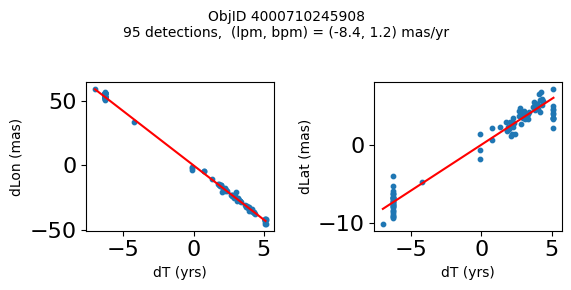

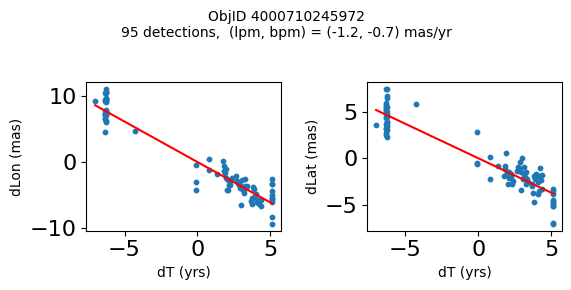

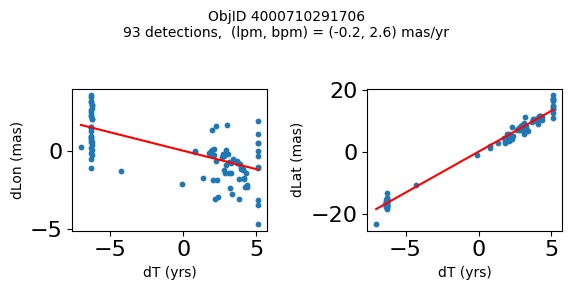

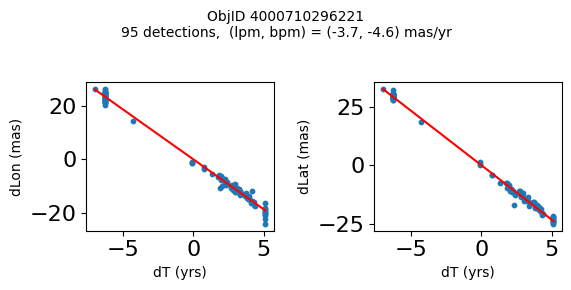

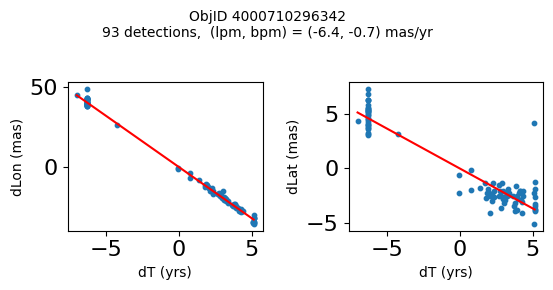

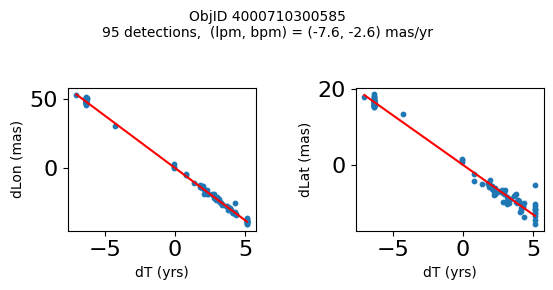

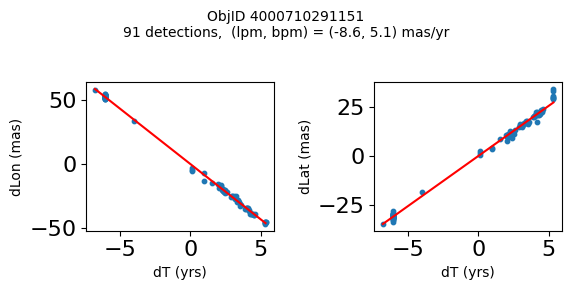

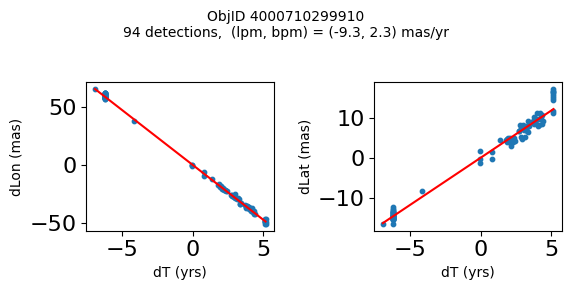

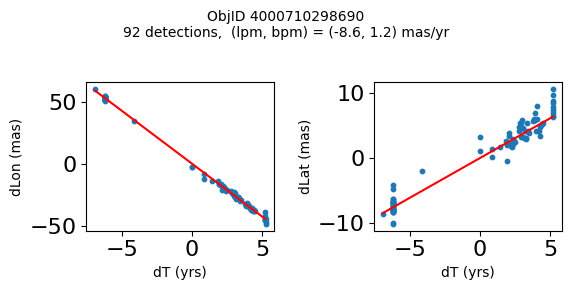

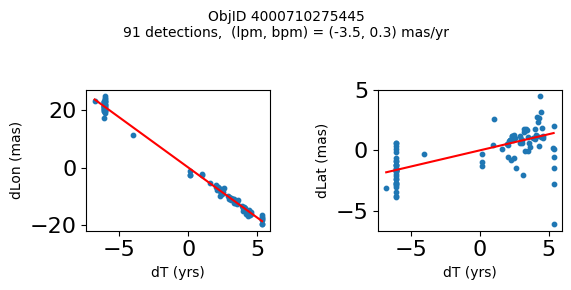

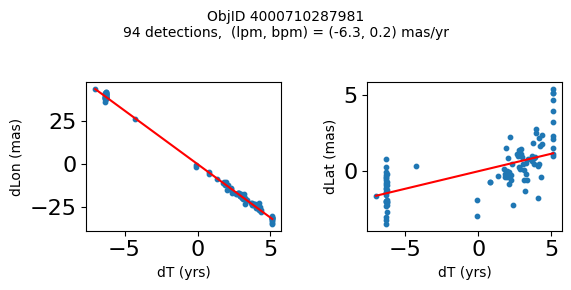

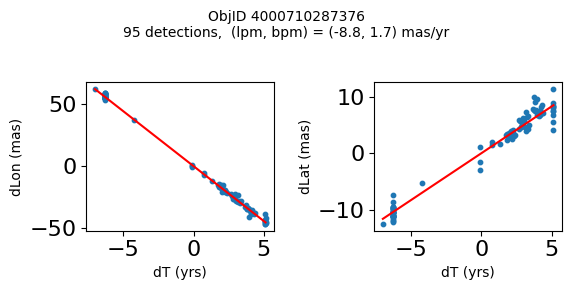

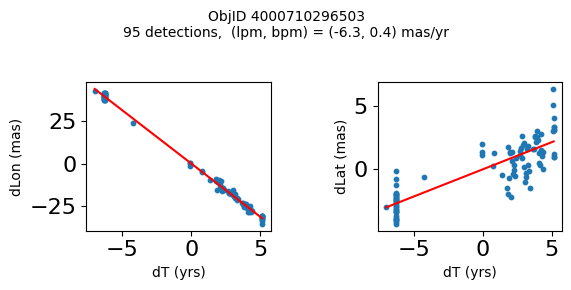

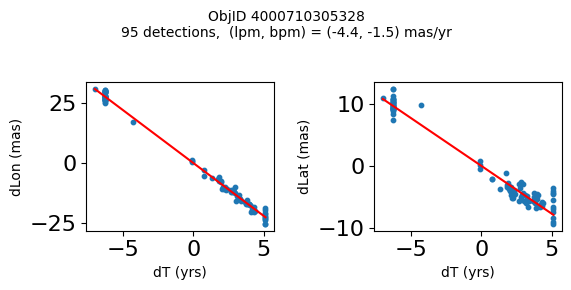

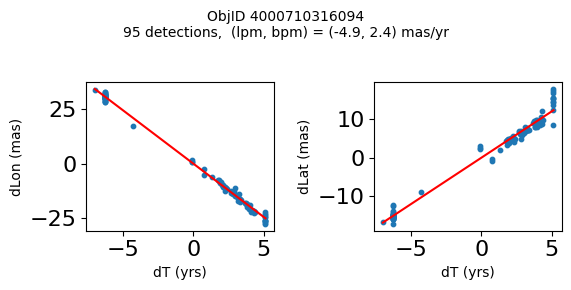

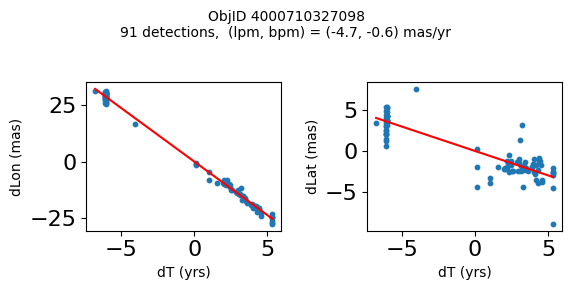

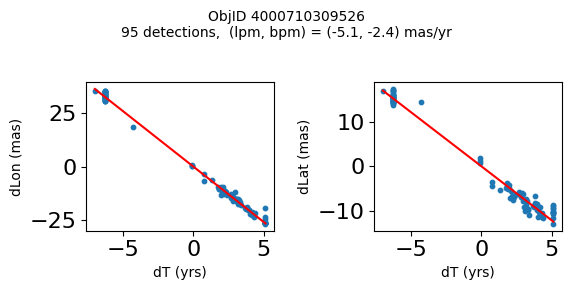

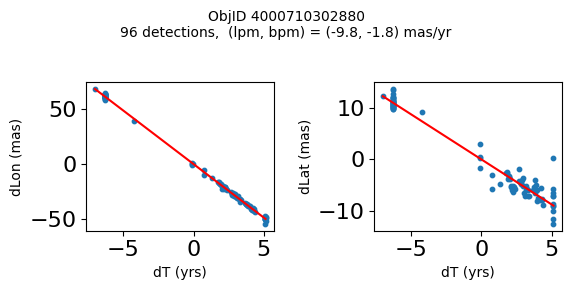

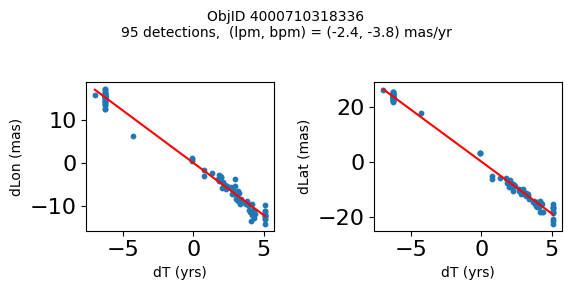

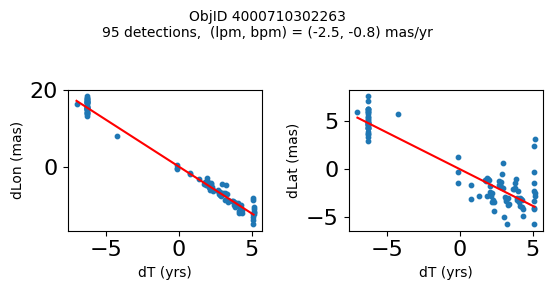

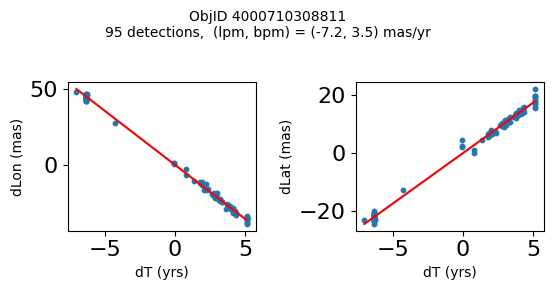

In [18]:
n = tab['NumVisits']
dev = tab['pmdev']
objid = tab['ObjID']
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
wi = np.where((dev < 1.5) & (n > 90) & (np.sqrt(bpmerr0**2+lpmerr0**2) < 1.0))[0]
print(f"Plotting {len(wi)} objects")
for o in objid[wi]:
    positions(o)

# Science Applications <a class="anchor" id="sciap"></a>

## High Proper Motion Objects  <a class="anchor" id="hpm"></a>

Get a list of objects with high, accurately measured proper motions.
Proper motions are measured relative to the Galactic center.

Plotting 31 objects


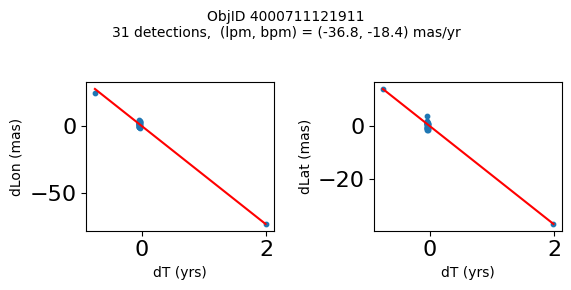

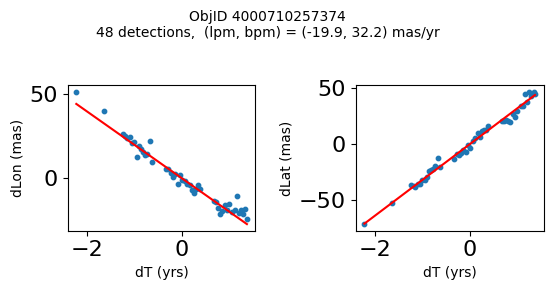

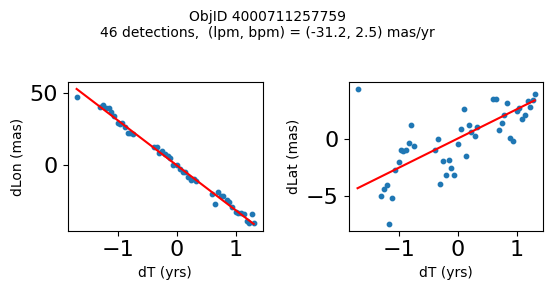

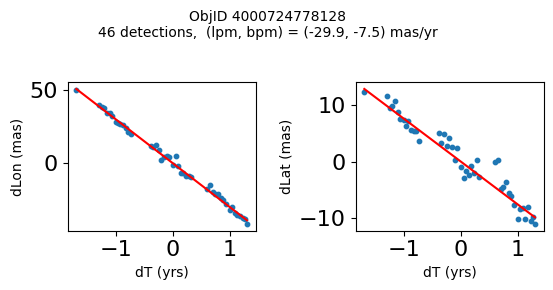

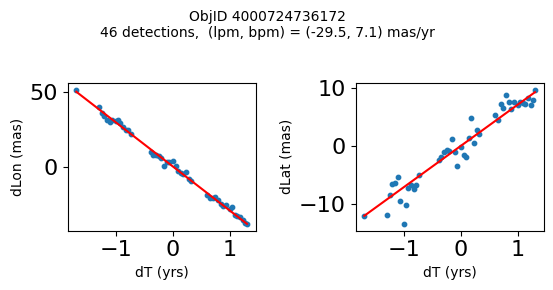

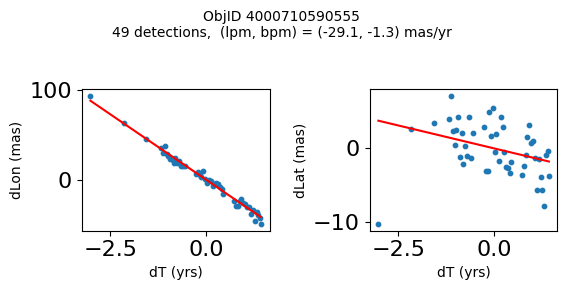

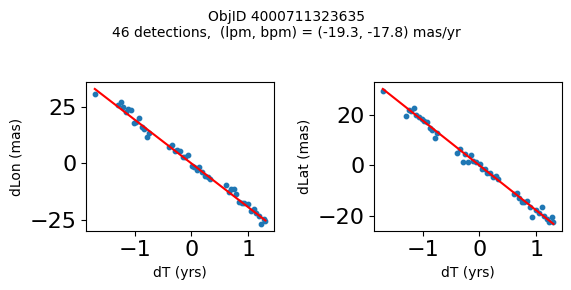

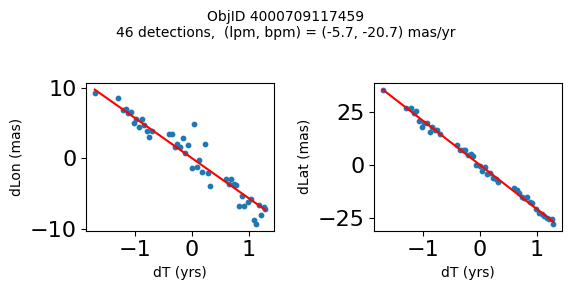

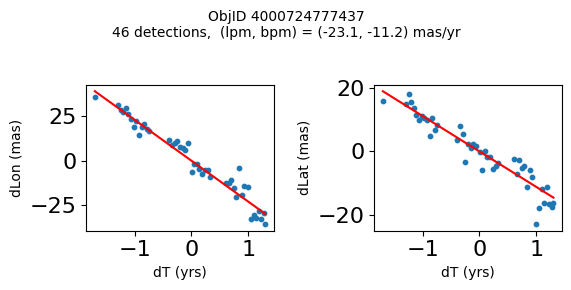

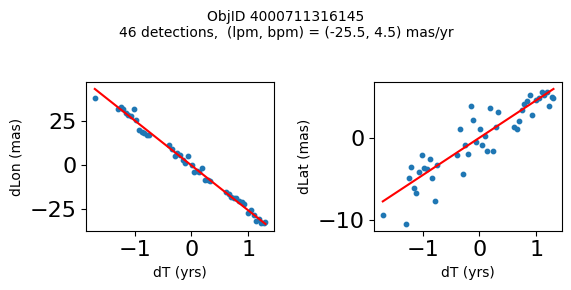

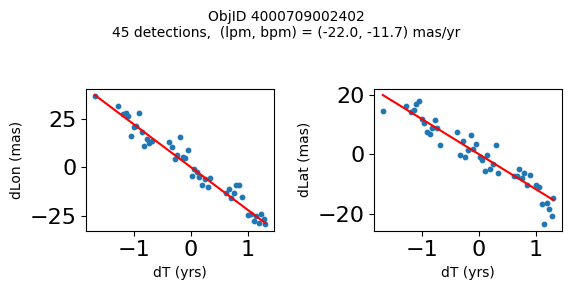

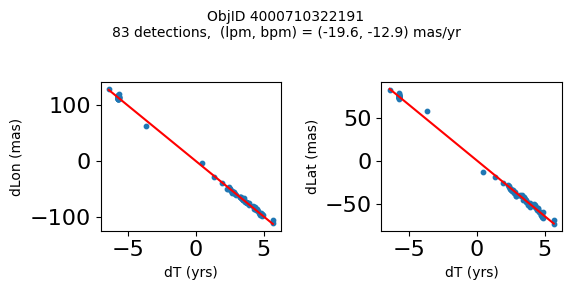

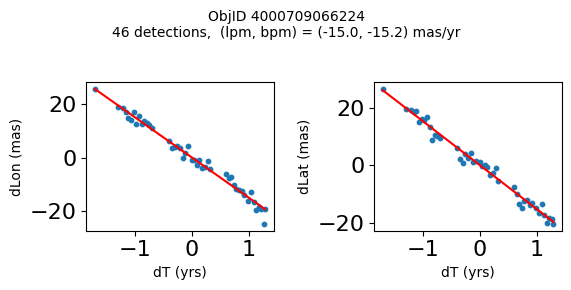

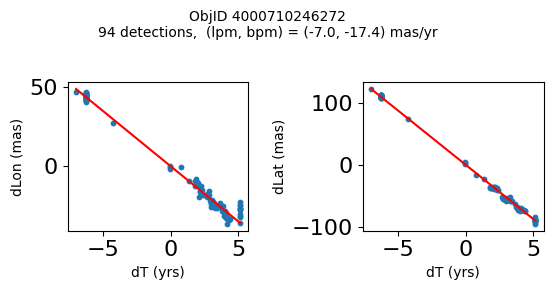

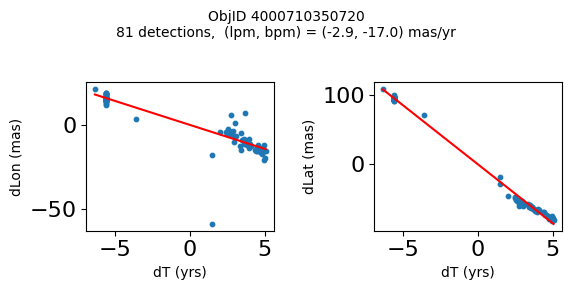

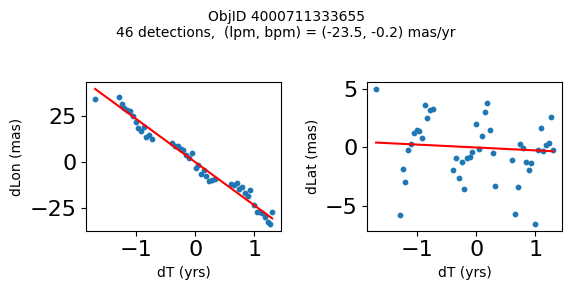

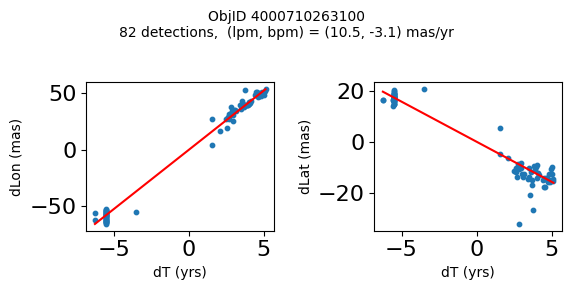

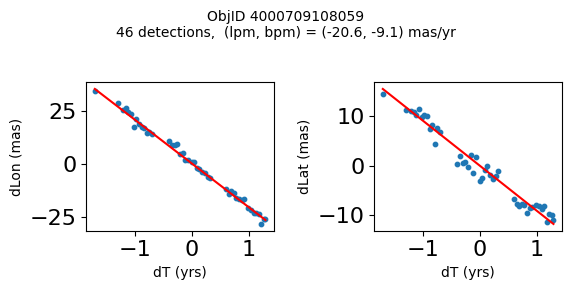

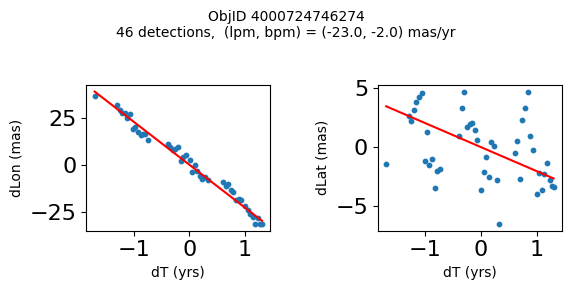

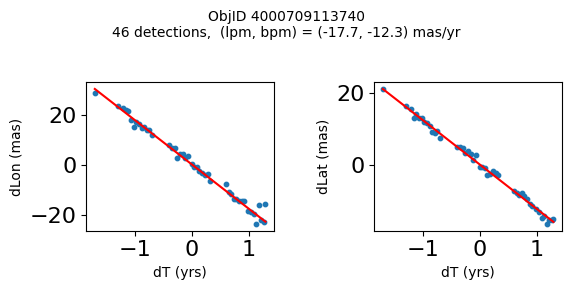

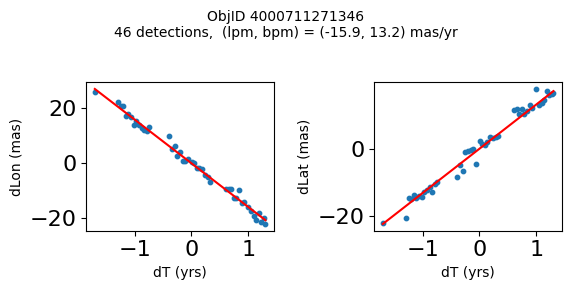

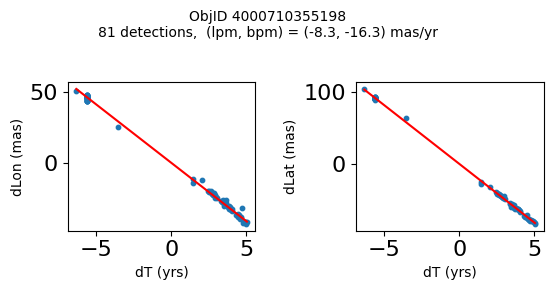

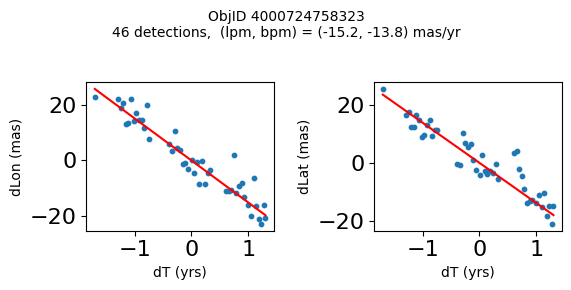

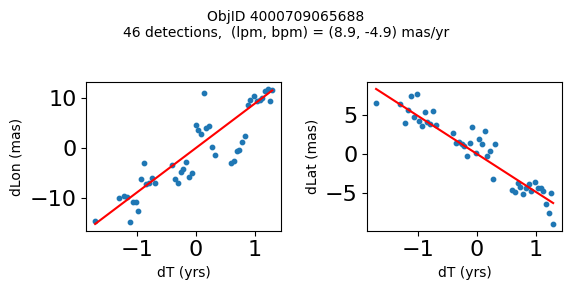

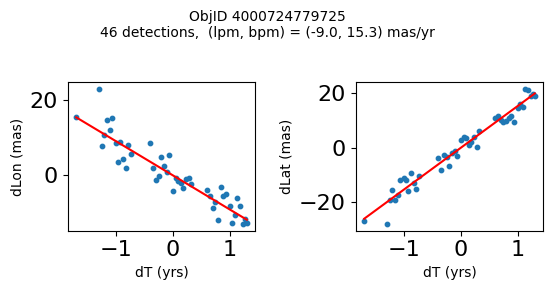

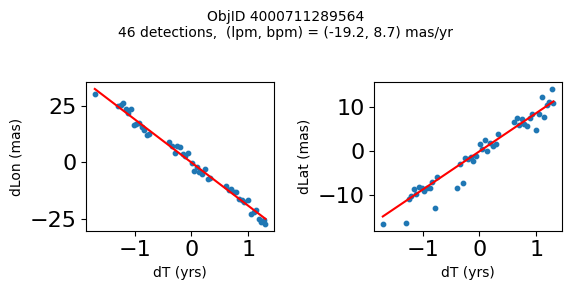

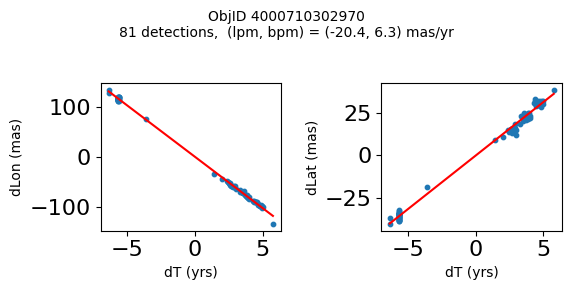

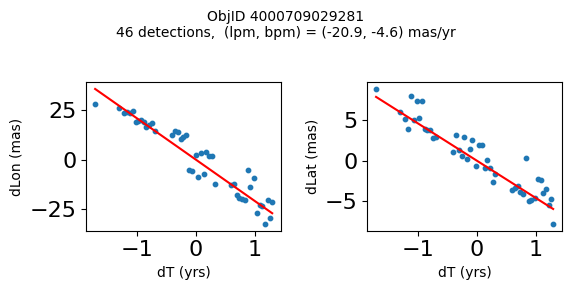

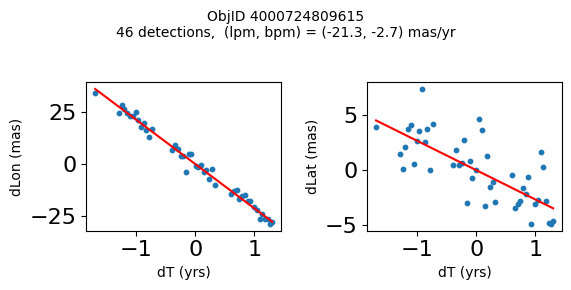

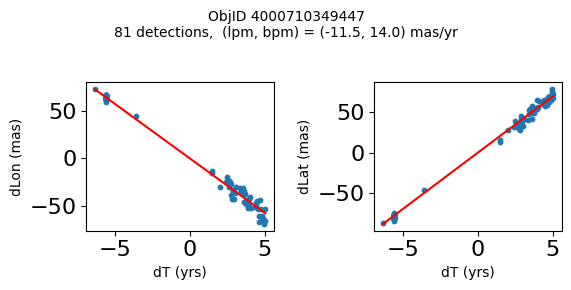

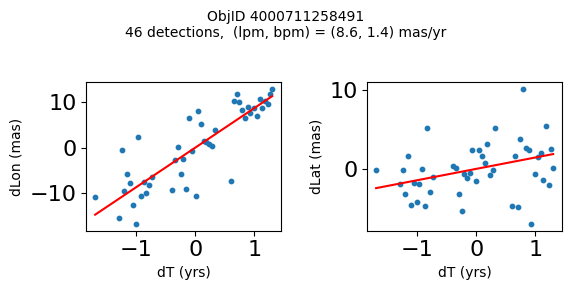

In [19]:
lpm_sgra = -6.379 # +- 0.026
bpm_sgra = -0.202 # +- 0.019

lpm0 = np.array(tab['lpm'])
bpm0 = np.array(tab['bpm'])
lpmerr0 = np.array(tab['lpmerr'])
bpmerr0 = np.array(tab['bpmerr'])
pmtot0 = np.sqrt((bpm0-bpm_sgra)**2+(lpm0-lpm_sgra)**2)
pmerr0 = np.sqrt(bpmerr0**2+lpmerr0**2)
dev = tab['pmdev']

# sort samples by decreasing PM
wpmh = np.where((pmtot0 > 15) & (pmerr0 < 1.0) & (dev < 5))[0]
wpmh = wpmh[np.argsort(-pmtot0[wpmh])]

print(f"Plotting {len(wpmh)} objects")
for o in tab["ObjID"][wpmh]:
    positions(o)

## Get HLA cutout images for selected objects  <a class="anchor" id="cutouts"></a>

Get HLA color cutout images for the high-PM objects.  The `query_hla` function gets a table of all the color images that are available at a given position using the f814w+f606w filters.  The `get_image` function reads a single cutout image (as a JPEG color image) and returns a PIL image object.

See the documentation on [HLA VO services](http://hla.stsci.edu/hla_help.html#services) and the [fitscut image cutout service](http://hla.stsci.edu/fitscutcgi_interface.html) for more information on the web services being used.

In [20]:
def query_hla(ra, dec, size=0.0, imagetype="color", inst="ACS", format="image/jpeg",
              spectral_elt=("f814w", "f606w"), autoscale=95.0, asinh=1, naxis=33):
    # convert a list of filters to a comma-separated string
    if not isinstance(spectral_elt, str):
        spectral_elt = ",".join(spectral_elt)
    siapurl = ("https://hla.stsci.edu/cgi-bin/hlaSIAP.cgi?"
               f"pos={ra},{dec}&size={size}&imagetype={imagetype}&inst={inst}"
               f"&format={format}&spectral_elt={spectral_elt}"
               f"&autoscale={autoscale}&asinh={asinh}"
               f"&naxis={naxis}")
    votable = Table.read(siapurl, format="votable")
    return votable


def get_image(url):
    """Get image from a URL"""
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im

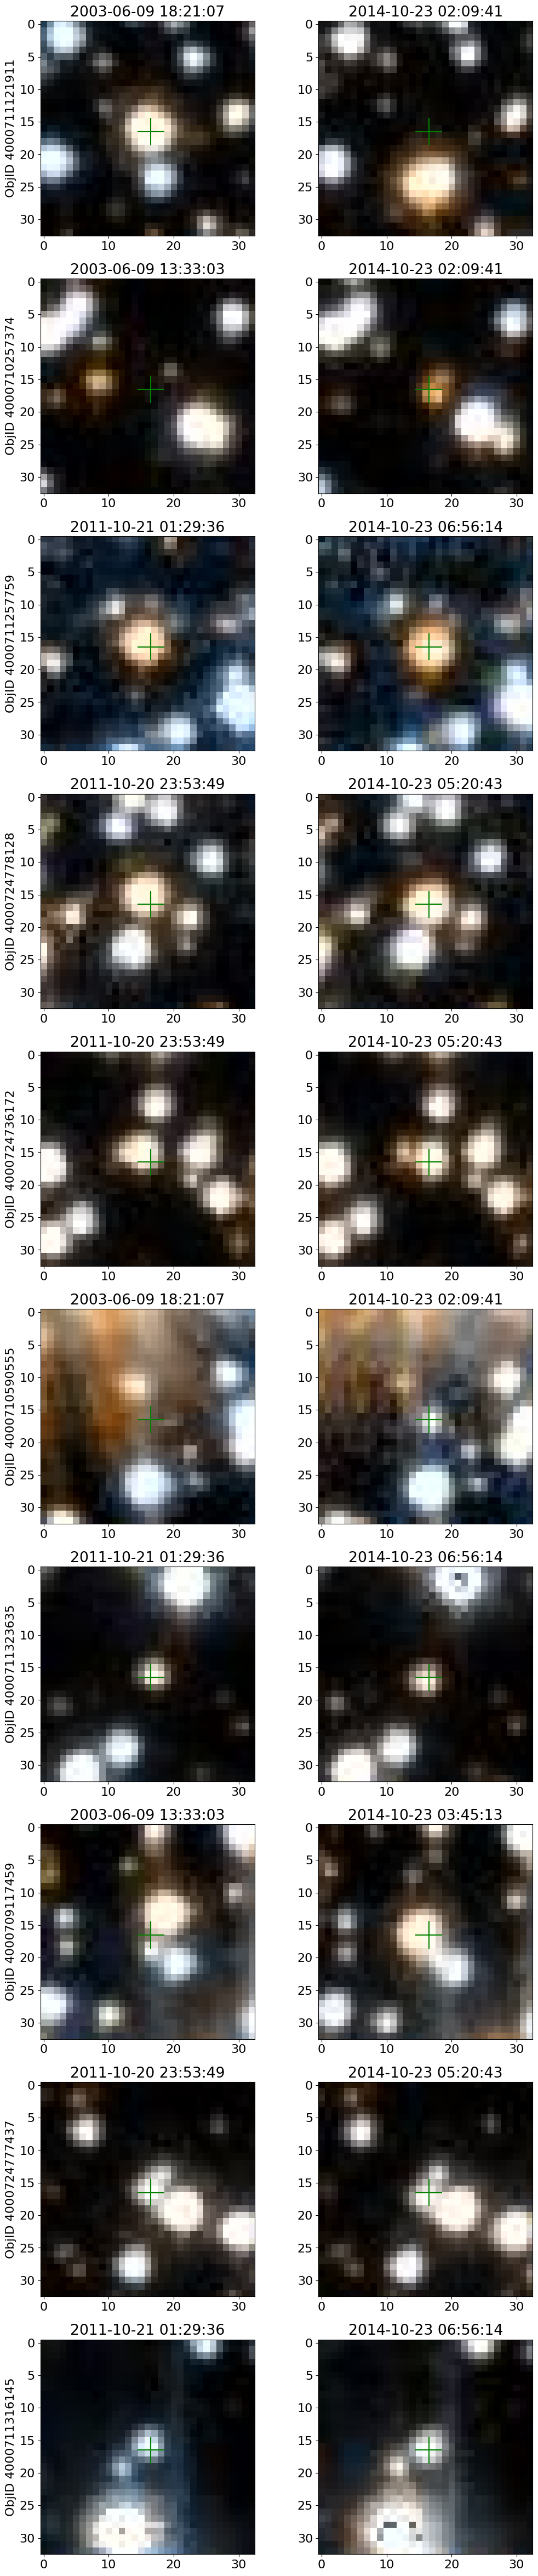

In [21]:
# display earliest and latest images side-by-side
# top 10 highest PM objects
wsel = wpmh[:10]
nim = len(wsel)
icols = 1        # objects per row
ncols = 2*icols  # two images for each object
nrows = (nim+icols-1)//icols

imsize = 33
xcross = np.array([-1, 1, 0, 0, 0])*2 + imsize/2
ycross = np.array([0, 0, 0, -1, 1])*2 + imsize/2

# selected data from tab
sd = tab[['RA', 'Dec', 'ObjID']][wsel]

# create the figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, (12/ncols)*nrows))

# iterate each observation, and each set of axes for the first and last image
for (ax1, ax2), obj in zip(axes, sd):
    
    # get the image urls and observation datetime
    hlatab = query_hla(obj["RA"], obj["Dec"], naxis=imsize)[['URL', 'StartTime']]
    # sort the data by the observation datetime, and get the first and last observation url
    (url1, time1), (url2, time2) = hlatab[np.argsort(hlatab['StartTime'])][[0, -1]]
    
    # get the images
    im1 = get_image(url1)
    im2 = get_image(url2)
    
    # plot the images
    ax1.imshow(im1, origin="upper")
    ax2.imshow(im2, origin="upper")
    
    # plot the center
    ax1.plot(xcross, ycross, 'g')
    ax2.plot(xcross, ycross, 'g')
    
    # labels and titles
    ax1.set(ylabel=f'ObjID {obj["ObjID"]}', title=time1)
    ax2.set_title(time2)

## Look at the entire collection of images for the highest PM object

In [22]:
i = wpmh[0]

# selected data
sd = tab['ObjID', 'RA', 'Dec', 'bpm', 'lpm', 'yr', 'dT'][i]
display(sd)

imsize = 33
# get the URL and StartTime data
hlatab = query_hla(sd['RA'], sd['Dec'], naxis=imsize)[['URL', 'StartTime']]
# sort the data
hlatab = hlatab[np.argsort(hlatab['StartTime'])]

nim = len(hlatab)
ncols = 8
nrows = (nim+ncols-1)//ncols

xcross = np.array([-1, 1, 0, 0, 0])*2 + imsize/2
ycross = np.array([0, 0, 0, -1, 1])*2 + imsize/2

<Row index=212993>
    ObjID             RA                Dec                bpm                lpm                 yr                dT       
    int64          float64            float64            float64            float64            float64           float64     
------------- ----------------- ------------------- ------------------ ------------------ ----------------- -----------------
4000711121911 269.7367256594695 -29.209699919117618 -18.43788346257518 -36.80145933087569 2004.194238143401 2.749260607770275

In [23]:
# get the images: takes about 90 seconds for 77 images
images = [get_image(url) for url in hlatab['URL']]

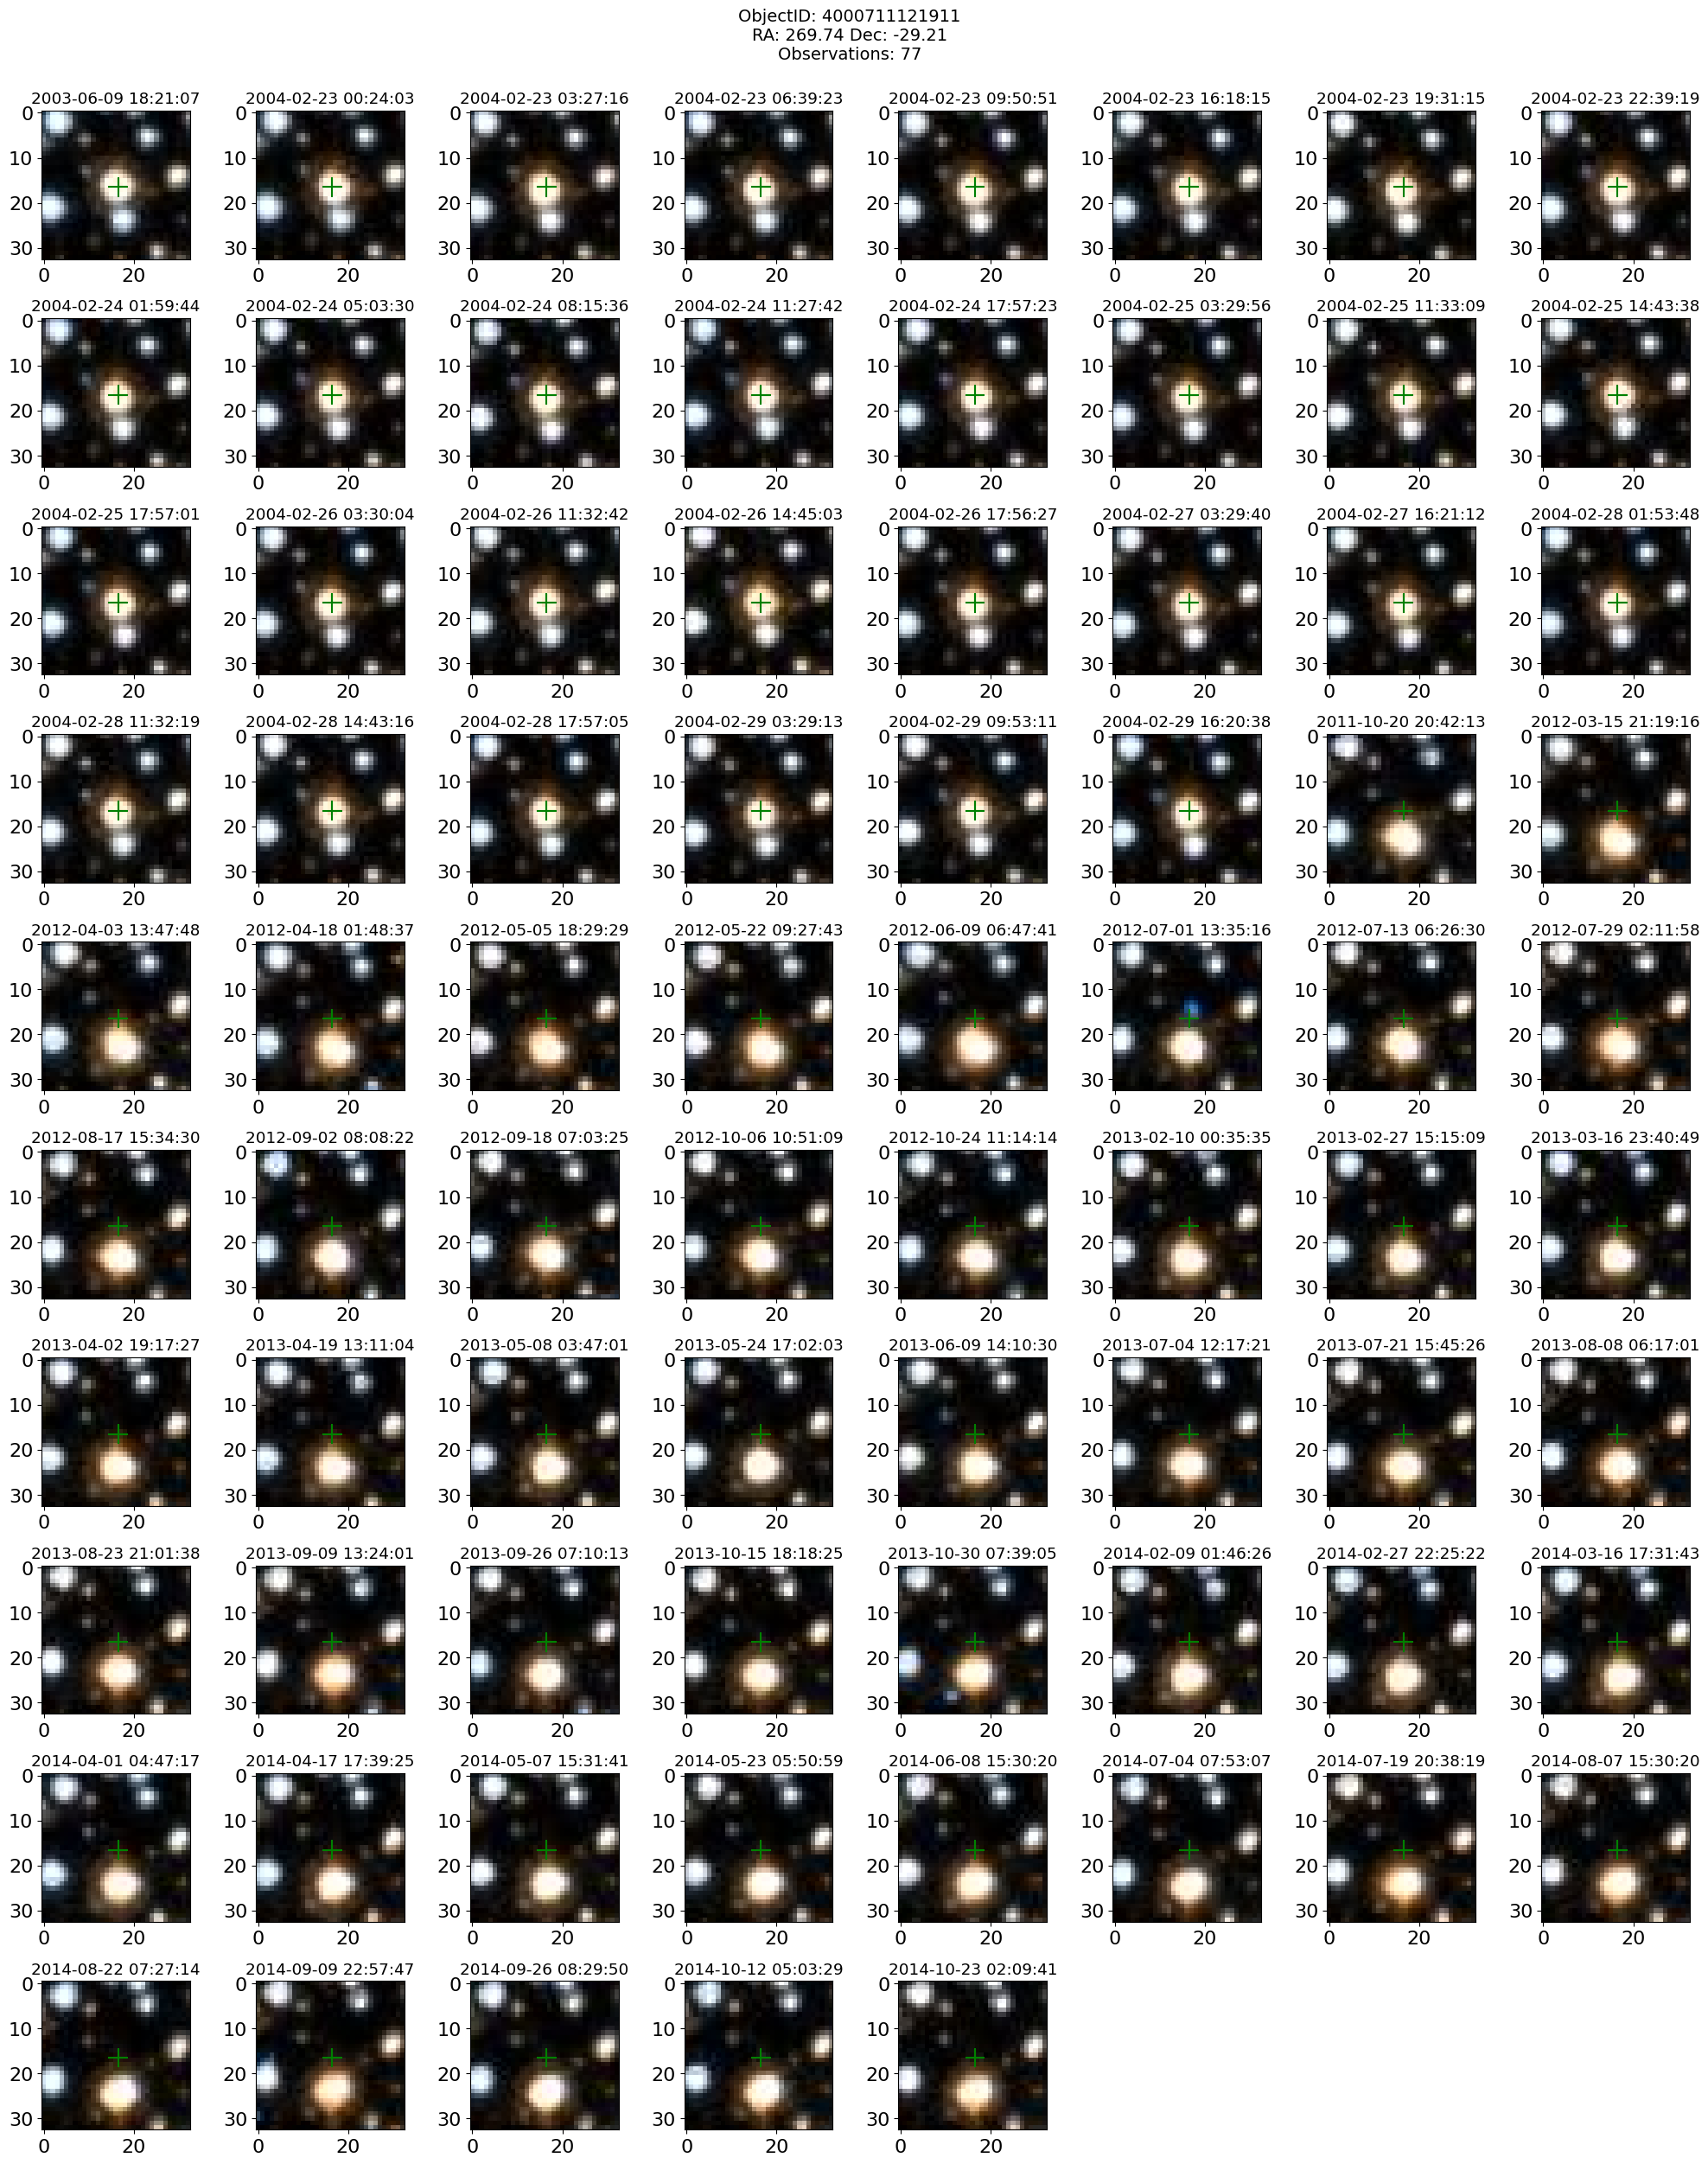

In [24]:
# create the figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, (20/ncols)*nrows))
# flatten the axes for easy iteration and zipping
axes = axes.flat

plt.rcParams.update({"font.size": 11})
for ax, time1, img in zip(axes, hlatab['StartTime'], images):
    # plot image
    ax.imshow(img, origin="upper")
    # plot the center
    ax.plot(xcross, ycross, 'g')
    # set the title
    ax.set_title(time1)
    
# remove the last 3 unused axes
for ax in axes[nim:]:
    ax.remove()

fig.suptitle(f"ObjectID: {sd['ObjID']}\nRA: {sd['RA']:0.2f} Dec: {sd['Dec']:0.2f}\nObservations: {nim}", y=1, fontsize=14)
fig.tight_layout()